In [1]:
import warnings
warnings.filterwarnings("ignore")
file = 'owid-covid-data.csv'

In [2]:
import pyspark
from pyspark.sql import SparkSession, SQLContext

spark = SparkSession.builder.appName("Covid Data Mining").config('spark.sql.debug.maxToStringFields', 2000).getOrCreate()
full_df = spark.read.csv(file, header=True, inferSchema=True)

22/06/16 11:25:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/16 11:25:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/06/16 11:25:02 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/06/16 11:25:02 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/06/16 11:25:02 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
22/06/16 11:25:02 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.


In [3]:
print(f"The total number of samples is {full_df.count()}, with each sample corresponding to {len(full_df.columns)} features.")


The total number of samples is 193812, with each sample corresponding to 67 features.


In [4]:
full_df.printSchema()


root
 |-- iso_code: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- location: string (nullable = true)
 |-- date: string (nullable = true)
 |-- total_cases: double (nullable = true)
 |-- new_cases: double (nullable = true)
 |-- new_cases_smoothed: double (nullable = true)
 |-- total_deaths: double (nullable = true)
 |-- new_deaths: double (nullable = true)
 |-- new_deaths_smoothed: double (nullable = true)
 |-- total_cases_per_million: double (nullable = true)
 |-- new_cases_per_million: double (nullable = true)
 |-- new_cases_smoothed_per_million: double (nullable = true)
 |-- total_deaths_per_million: double (nullable = true)
 |-- new_deaths_per_million: double (nullable = true)
 |-- new_deaths_smoothed_per_million: double (nullable = true)
 |-- reproduction_rate: double (nullable = true)
 |-- icu_patients: double (nullable = true)
 |-- icu_patients_per_million: double (nullable = true)
 |-- hosp_patients: double (nullable = true)
 |-- hosp_patients_per_million

In [5]:
full_df.select("iso_code","location","continent","date","tests_units").show(5)


+--------+-----------+---------+----------+-----------+
|iso_code|   location|continent|      date|tests_units|
+--------+-----------+---------+----------+-----------+
|     AFG|Afghanistan|     Asia|2020-02-24|       null|
|     AFG|Afghanistan|     Asia|2020-02-25|       null|
|     AFG|Afghanistan|     Asia|2020-02-26|       null|
|     AFG|Afghanistan|     Asia|2020-02-27|       null|
|     AFG|Afghanistan|     Asia|2020-02-28|       null|
+--------+-----------+---------+----------+-----------+
only showing top 5 rows



In [6]:
from pyspark.sql import functions as F

miss_vals = full_df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in full_df.columns]).collect()[0].asDict()
miss_vals = dict(sorted(miss_vals.items(), reverse=True, key=lambda item: item[1]))

import pandas as pd

pd.DataFrame.from_records([miss_vals])

,weekly_icu_admissions,weekly_icu_admissions_per_million,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_boosters,total_boosters_per_hundred,...,new_cases_smoothed_per_million,new_cases_smoothed,new_cases_per_million,total_cases_per_million,new_cases,total_cases,population,iso_code,location,date
0,187513,187513,187206,187206,187206,187206,181263,181263,168630,168630,...,9980,9127,8811,8546,7953,7688,1175,0,0,0


In [7]:
full_df = full_df.withColumn('date',F.to_date(F.unix_timestamp(F.col('date'), 'yyyy-MM-dd').cast("timestamp")))


In [9]:
dates = ("2021-01-01", "2021-02-28") 
#europ change
# dates = ("2021-06-12", "2022-06-12")

df = full_df.where(F.col('date').between(*dates))

In [10]:
print(f"The total number of samples is {df.count()}, with each sample corresponding to {len(df.columns)} features.")

miss_vals = df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).collect()[0].asDict()
miss_vals = dict(sorted(miss_vals.items(), reverse=True, key=lambda item: item[1]))

pd.DataFrame.from_records([miss_vals])

The total number of samples is 13574, with each sample corresponding to 67 features.


,weekly_icu_admissions,weekly_icu_admissions_per_million,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,total_boosters,total_boosters_per_hundred,weekly_hosp_admissions,weekly_hosp_admissions_per_million,...,new_cases_smoothed_per_million,new_cases_per_million,total_cases_per_million,new_cases_smoothed,new_cases,total_cases,population,iso_code,location,date
0,13089,13089,13059,13059,13059,13059,12800,12800,12640,12640,...,446,441,437,387,382,378,105,0,0,0


In [11]:
df.sort("continent").select("iso_code","continent","location").show(5)


+--------+---------+--------+
|iso_code|continent|location|
+--------+---------+--------+
|OWID_EUR|     null|  Europe|
|OWID_EUR|     null|  Europe|
|OWID_EUR|     null|  Europe|
|OWID_EUR|     null|  Europe|
|OWID_EUR|     null|  Europe|
+--------+---------+--------+
only showing top 5 rows



In [12]:
df = df.fillna({'continent':'OWID'})


In [13]:
df.select("tests_units").distinct().show()


+---------------+
|    tests_units|
+---------------+
|           null|
|  people tested|
| samples tested|
|tests performed|
|  units unclear|
+---------------+



In [14]:
df = df.fillna({'tests_units':'no info'})


In [15]:
df = df.fillna(0)


In [16]:
miss_vals = df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).collect()[0].asDict()
if any(list(miss_vals.values())) != 0:
    print("There are still missing values in the DataFrame.")
else:
    print("All missing values have been taken care of.")

All missing values have been taken care of.


In [17]:
def OutlierDetector(dataframe, features, alpha=1.5):
    """
    Args:
        dataframe (pyspark.sql.dataframe.DataFrame):
            the DataFrame hosting the data
        features (string or List):
            List of features (columns) for which we wish to identify outliers.
            If set equal to 'all', outliers are identified with respect to all features.
        alpha (double):
            The parameter that defines the decision boundary (see markdown above)
    """
    feat_types = dict(dataframe.dtypes)
    if features == 'all':
        features = dataframe.columns
        
    outliers_cols = []
    
    for feat in features:
        # We only care for quantitative features
        if feat_types[feat] == 'double':
            Q1, Q3 = dataframe.approxQuantile(feat, [0.25, 0.75], 0)
            R = Q3 - Q1
            lower_bound = Q1 - (R * alpha)
            upper_bound = Q3 + (R * alpha)
            
            # In this way we construct a query, which can be matched to a DataFrame column, thus returning a new
            # column where every point that corresponds to an Outlier has a boolean value set to True
            outliers_cols.append(F.when(~F.col(feat).between(lower_bound, upper_bound), True).alias(feat + '_outlier'))
    
    # Sample points that do not correspond to outliers correspond to a False value for the new column
    outlier_df = dataframe.select(*outliers_cols)
    outlier_df = outlier_df.fillna(False)
    return outlier_df

In [18]:
out_df = OutlierDetector(dataframe=df, features=['new_cases'], alpha=1.5)
out_df.show(5)

+-----------------+
|new_cases_outlier|
+-----------------+
|            false|
|            false|
|            false|
|            false|
|            false|
+-----------------+
only showing top 5 rows



In [19]:
if df.count() != df.select(['location','date']).distinct().count():
    print("There are duplicate entries present in the DataFrame.")
else:
    print("Either there are no duplicate entries present in the DataFrame, or all of them have already been removed).")

Either there are no duplicate entries present in the DataFrame, or all of them have already been removed).


In [20]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import ListedColormap, LinearSegmentedColormap, TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

def CustomCmap(from_rgb,to_rgb):

    # from color r,g,b
    r1,g1,b1 = from_rgb

    # to color r,g,b
    r2,g2,b2 = to_rgb

    cdict = {'red': ((0, r1, r1),
                   (1, r2, r2)),
           'green': ((0, g1, g1),
                    (1, g2, g2)),
           'blue': ((0, b1, b1),
                   (1, b2, b2))}

    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap

mycmap = CustomCmap([1.0, 1.0, 1.0], [72/255, 99/255, 147/255])
mycmap_r = CustomCmap([72/255, 99/255, 147/255], [1.0, 1.0, 1.0])

mycol = (72/255, 99/255, 147/255)
mycomplcol = (129/255, 143/255, 163/255)
othercol1 = (135/255, 121/255, 215/255)
othercol2 = (57/255, 119/255, 171/255)
othercol3 = (68/255, 81/255, 91/255)
othercol4 = (73/255, 149/255, 139/255)

In [21]:
dates_frame = df.select("date").distinct().orderBy('date').collect()
dates_list = [str(dates_frame[x][0]) for x in range(len(dates_frame))]

In [22]:
df_for_mort = df.filter(F.col('population') != 0.0).withColumn("mortality", F.col("total_deaths")/F.col("population"))

for i, this_day in enumerate(dates_list):
    this_day_top_10 = df_for_mort.filter(F.col('date') == this_day).orderBy("mortality", ascending=False).select(["location","mortality"]).take(10)
    if i == 0:
        ct_list = [(this_day_top_10[x][0],this_day_top_10[x][1]) for x in range(10)]
        print("During "+this_day+", the top 10 countries with the highest mortality rate were:")
        for country, instance in ct_list:
            print(f"▶ {country}, with mortality rate {100*instance:.2f}%.")
        new_set = set(ct_list[x][0] for x in range(10))
    elif i == len(dates_list)-1:
        ct_list = [(this_day_top_10[x][0],this_day_top_10[x][1]) for x in range(10)]
        print("During "+this_day+", the top 10 countries with the highest mortality rate were:")
        for country, instance in ct_list:
            print(f"▶ {country}, with mortality rate {100*instance:.2f}%.")
    else:
        new_set = set(this_day_top_10[x][0] for x in range(10))
        if new_set != old_set:
            left_out = old_set-new_set
            new_additions = new_set-old_set
            print("This was the top ten until "+this_day+", when "+", ".join(str(s) for s in new_additions)+" joined the list, replacing "+", ".join(str(s) for s in left_out)+".")
    new_set, old_set = set(), new_set

During 2021-01-01, the top 10 countries with the highest mortality rate were:
▶ Peru, with mortality rate 0.28%.
▶ San Marino, with mortality rate 0.17%.
▶ Belgium, with mortality rate 0.17%.
▶ Slovenia, with mortality rate 0.13%.
▶ Bosnia and Herzegovina, with mortality rate 0.13%.
▶ Italy, with mortality rate 0.12%.
▶ North Macedonia, with mortality rate 0.12%.
▶ Liechtenstein, with mortality rate 0.12%.
▶ Bulgaria, with mortality rate 0.11%.
▶ Czechia, with mortality rate 0.11%.
This was the top ten until 2021-01-08, when United Kingdom joined the list, replacing Bulgaria.
This was the top ten until 2021-01-18, when Gibraltar joined the list, replacing North Macedonia.
This was the top ten until 2021-02-03, when North Macedonia joined the list, replacing Liechtenstein.
This was the top ten until 2021-02-06, when United States joined the list, replacing North Macedonia.
This was the top ten until 2021-02-08, when North Macedonia joined the list, replacing United States.
This was the 

In [23]:
for i, this_day in enumerate(dates_list):
    this_day_top_10 = df.filter(F.col('date') == this_day).orderBy("total_cases_per_million", ascending=False).select(["location","total_cases_per_million"]).take(10)
    if i == 0:
        ct_list = [(this_day_top_10[x][0],this_day_top_10[x][1]) for x in range(10)]
        print("During "+this_day+", the top 10 countries with the highest number of total cases per million were:")
        for country, instance in ct_list:
            print(f"▶ {country}, with {instance} total cases per million.")
        new_set = set(ct_list[x][0] for x in range(10))
    elif i == len(dates_list)-1:
        ct_list = [(this_day_top_10[x][0],this_day_top_10[x][1]) for x in range(10)]
        print("During "+this_day+", the top 10 countries with the highest number of total cases per million were:")
        for country, instance in ct_list:
            print(f"▶ {country}, with {instance} total cases per million.")
    else:
        new_set = set(this_day_top_10[x][0] for x in range(10))
        if new_set != old_set:
            left_out = old_set-new_set
            new_additions = new_set-old_set
            print("This was the top ten until "+this_day+", when "+", ".join(str(s) for s in new_additions)+" joined the list, replacing "+", ".join(str(s) for s in left_out)+".")
    new_set, old_set = set(), new_set

During 2021-01-01, the top 10 countries with the highest number of total cases per million were:
▶ Andorra, with 104933.164 total cases per million.
▶ Montenegro, with 77364.736 total cases per million.
▶ Luxembourg, with 73115.905 total cases per million.
▶ San Marino, with 70097.03 total cases per million.
▶ Czechia, with 68256.644 total cases per million.
▶ Gibraltar, with 65655.516 total cases per million.
▶ United States, with 61187.458 total cases per million.
▶ French Polynesia, with 59907.834 total cases per million.
▶ Slovenia, with 59627.954 total cases per million.
▶ Liechtenstein, with 58686.673 total cases per million.
This was the top ten until 2021-01-07, when Panama joined the list, replacing French Polynesia.
This was the top ten until 2021-01-13, when Slovakia joined the list, replacing Liechtenstein.
This was the top ten until 2021-02-05, when Portugal joined the list, replacing Panama.
This was the top ten until 2021-02-10, when Israel joined the list, replacing Por

In [24]:
# df.limit(3).toPandas() 
# df.filter(df.iso_code=="CHN").select(["date","hosp_patients"]).show(200)

In [25]:
dates_list

['2021-01-01',
 '2021-01-02',
 '2021-01-03',
 '2021-01-04',
 '2021-01-05',
 '2021-01-06',
 '2021-01-07',
 '2021-01-08',
 '2021-01-09',
 '2021-01-10',
 '2021-01-11',
 '2021-01-12',
 '2021-01-13',
 '2021-01-14',
 '2021-01-15',
 '2021-01-16',
 '2021-01-17',
 '2021-01-18',
 '2021-01-19',
 '2021-01-20',
 '2021-01-21',
 '2021-01-22',
 '2021-01-23',
 '2021-01-24',
 '2021-01-25',
 '2021-01-26',
 '2021-01-27',
 '2021-01-28',
 '2021-01-29',
 '2021-01-30',
 '2021-01-31',
 '2021-02-01',
 '2021-02-02',
 '2021-02-03',
 '2021-02-04',
 '2021-02-05',
 '2021-02-06',
 '2021-02-07',
 '2021-02-08',
 '2021-02-09',
 '2021-02-10',
 '2021-02-11',
 '2021-02-12',
 '2021-02-13',
 '2021-02-14',
 '2021-02-15',
 '2021-02-16',
 '2021-02-17',
 '2021-02-18',
 '2021-02-19',
 '2021-02-20',
 '2021-02-21',
 '2021-02-22',
 '2021-02-23',
 '2021-02-24',
 '2021-02-25',
 '2021-02-26',
 '2021-02-27',
 '2021-02-28']

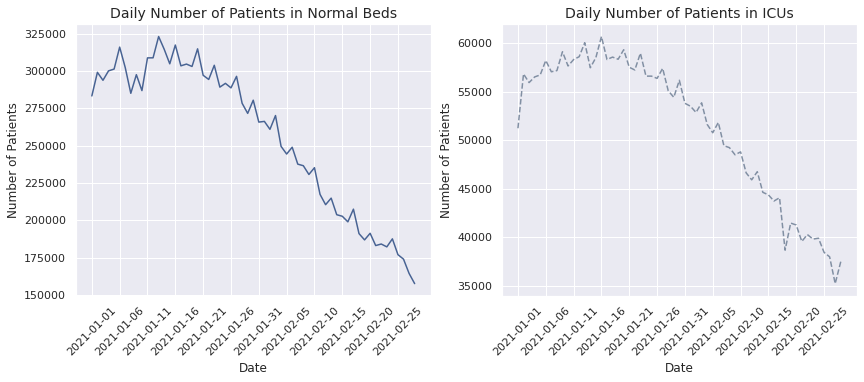

In [26]:
# dt_ord = df.filter(df.iso_code=="CHN").orderBy("date", ascending=True).groupBy("date")
dt_ord = df.orderBy("date", ascending=True).groupBy("date")

hosps = dt_ord.agg(F.sum("hosp_patients")).collect()
hosps = [hosps[i][1] for i in range(len(hosps))]

icus = dt_ord.agg(F.sum("icu_patients")).collect()
icus = [icus[i][1] for i in range(len(icus))]

sns.set(style = "darkgrid")

alt_dts_list = [dt.replace('2022-', '') for dt in dates_list]
tick_marks = np.arange(len(alt_dts_list))

fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(14,5))

for pat, col, style, ax, where in zip([hosps,icus], [mycol, mycomplcol],
                                      ['solid', 'dashed'], [ax1,ax2], ['Normal Beds','ICUs']): 
    ax.plot(alt_dts_list, pat, linestyle=style, color=col)
    ax.set_xlabel("Date")
    ax.set_ylabel("Number of Patients")
    ax.set_title(f"Daily Number of Patients in {where}", fontsize=14)
    ax.set_xticks(tick_marks[::5])
    ax.set_xticklabels(alt_dts_list[::5], rotation=45)
    
plt.show()

matplotlib.rc_file_defaults()

In [27]:
import geopandas as gpd

shapefile = 'countries.shp'
geo_df = gpd.read_file(shapefile)[['ADMIN','ADM0_A3','geometry']]
geo_df.columns = ['location', 'iso_code', 'geometry']
geo_df = geo_df.drop(geo_df.loc[geo_df['location'] == 'Antarctica'].index) # exclude Antarctica

In [28]:
print('Initializing the construction of heatmaps for every day.')

ct = 0
for this_day in dates_list:
    # The conversion of the required columns into a Pandas df is necessary to perform the mapping
    day_df = df.filter(F.col('date') == this_day).select(["iso_code","total_cases"]).toPandas()

    merged_df = pd.merge(left=geo_df, right=day_df, how='left', left_on='iso_code', right_on='iso_code')

    title = f'Total COVID-19 Cases as of {this_day}'
    col = 'total_cases'
    vmin, vmax = merged_df[col].min(), merged_df[col].max()
    cmap = mycmap
    divnorm = TwoSlopeNorm(vcenter=0.08*20365726)

    # Create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(20, 8))

    # Remove the axis
    ax.axis('off')
    merged_df.plot(column=col, ax=ax, edgecolor='1.0', linewidth=1, norm=divnorm, cmap=cmap)

    # Add a title
    ax.set_title(title, fontdict={'fontsize': '25', 'fontweight': '3'})

    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)

    # Empty array for the data range
    sm._A = []

    # Add the colorbar to the figure
    cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
    cbar = fig.colorbar(sm, cax=cbaxes)
    plt.savefig(f'world_map_{this_day}.png', bbox_inches='tight')
    plt.close(fig)
    ct += 1

print(f'Process complete. {ct} heatmap(s) were extracted, ready to be converted into a .gif file.')

Initializing the construction of heatmaps for every day.
Process complete. 59 heatmap(s) were extracted, ready to be converted into a .gif file.


In [29]:
from PIL import Image

frames = []
for this_day in dates_list:
    frames.append(Image.open(f'world_map_{this_day}.png').resize((600,300),Image.ANTIALIAS))


frames = [frame.convert('PA') for frame in frames]

gif_name = 'Total COVID-19 Cases.gif'
frames[0].save(gif_name, format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=0, loop=0, transparency=3,quality=200,optimize=True)


In [30]:
exc_dates_list = df.filter(F.col('excess_mortality') != 0.0).select(['date']).distinct().orderBy('date').collect()
exc_dates_list = [str(exc_dates_list[i][0]) for i in range(len(exc_dates_list))]

In [31]:
print('Initializing the construction of heatmaps for every day.')

ct = 0
for this_day in exc_dates_list:
    europe_df = df.filter(F.col('date') == this_day).filter(F.col('continent') == 'Europe').filter(F.col('excess_mortality') != 0.0).select(["iso_code","excess_mortality"])
    
    geo_eu = pd.merge(left=geo_df, right=europe_df.toPandas(), how='inner', on='iso_code')

    fig, ax = plt.subplots(1,1)

    col = 'excess_mortality'
    cmap = mycmap

    vmin, vmax = geo_eu[col].min(), geo_eu[col].max()
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)

    ax.axis('off')
    ax.axis([-13, 44, 33, 72])
    geo_eu.plot(column=col, ax=ax, edgecolor='1.0', linewidth=1, norm=None, cmap=cmap)
    ax.set_title(f'Excess Mortality in Europe as of {this_day}', fontdict={'fontsize': '14', 'fontweight': '3'})
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=.2)
    fig.add_axes(cax)
    fig.colorbar(sm, cax=cax)
    plt.savefig(f'europe_{this_day}.png', bbox_inches='tight')
    plt.close(fig)
    ct += 1
    
print(f'Process complete. {ct} heatmap(s) were extracted, ready to be converted into a .gif file.')

Initializing the construction of heatmaps for every day.
Process complete. 9 heatmap(s) were extracted, ready to be converted into a .gif file.


In [32]:
from PIL import Image

frames = []
for this_day in exc_dates_list:
    frames.append(Image.open(f'europe_{this_day}.png'))


frames = [frame.convert('PA') for frame in frames]

gif_name = 'Excess Mortality in Europe.gif'
frames[0].save(gif_name, format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=1000, loop=0, transparency=8,quality=200,optimize=True)


In [33]:
european_df = df.filter(F.col('continent') == 'Europe').filter(F.col('excess_mortality') != 0.0)
european_cts = european_df.select(['location']).distinct().collect()
european_cts = [european_cts[i][0] for i in range(len(european_cts)) if european_df.filter(F.col('location') == european_cts[i][0]).count() == len(exc_dates_list)]
print(f'{len(european_cts)} European countries are chosen for this analysis.')

31 European countries are chosen for this analysis.


In [34]:
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window

eu_cts_df = european_df.filter(F.col('location') == european_cts[0]).select(['excess_mortality']).withColumnRenamed("excess_mortality", european_cts[0])
# required for the proper join of the following DataFrames
eu_cts_df = eu_cts_df.withColumn('row_index', row_number().over(Window.partitionBy(F.lit(0)).orderBy(monotonically_increasing_id())))

for country in european_cts[1:]:
    new_ct_df = european_df.filter(F.col('location') == country).select(['excess_mortality']).withColumnRenamed("excess_mortality", country)
    new_ct_df = new_ct_df.withColumn('row_index', row_number().over(Window.partitionBy(F.lit(0)).orderBy(monotonically_increasing_id())))
    
    eu_cts_df = eu_cts_df.join(new_ct_df, on=["row_index"])
    
eu_cts_df = eu_cts_df.drop("row_index")

In [35]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=eu_cts_df.columns, outputCol=vector_col)
df_vector = assembler.transform(eu_cts_df).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col, 'pearson')
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()

22/06/16 11:28:48 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/06/16 11:28:48 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


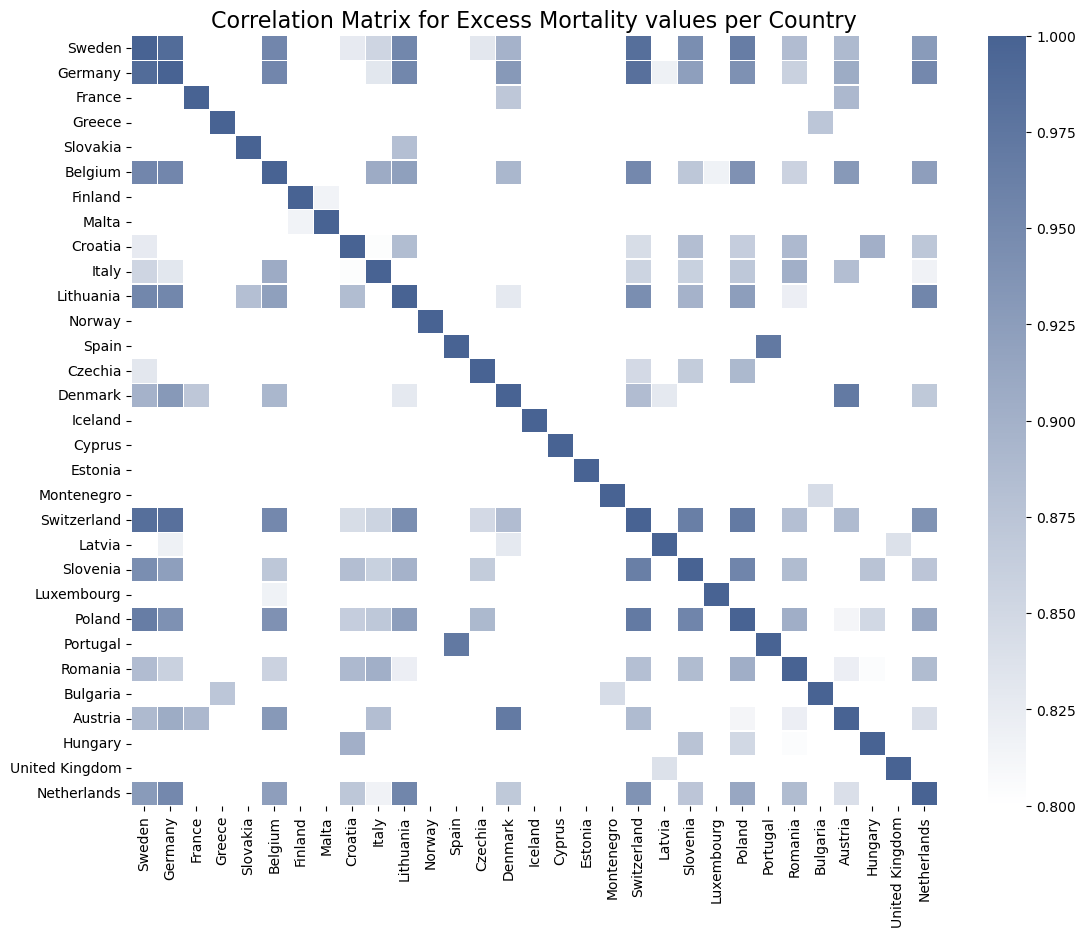

In [36]:
fig, ax = plt.subplots(figsize=(13,10))

sns.heatmap(cor_np, linewidths=.5, ax=ax, vmin=0.8, vmax=1, cmap=mycmap,
            xticklabels=european_cts, yticklabels=european_cts)
ax.set_title('Correlation Matrix for Excess Mortality values per Country', fontsize=16)
plt.show()

In [37]:
for i in range(len(european_cts)):
    for j in range(i+1,len(european_cts)):
        corr_val = cor_np[i][j]
        if corr_val > 0.8:
            print(f'{european_cts[i]} and {european_cts[j]} show a correlation of {100*corr_val:.2f}.')

Sweden and Germany show a correlation of 98.87.
Sweden and Belgium show a correlation of 95.42.
Sweden and Croatia show a correlation of 82.66.
Sweden and Italy show a correlation of 85.36.
Sweden and Lithuania show a correlation of 95.32.
Sweden and Czechia show a correlation of 83.08.
Sweden and Denmark show a correlation of 89.86.
Sweden and Switzerland show a correlation of 98.38.
Sweden and Slovenia show a correlation of 94.47.
Sweden and Poland show a correlation of 96.59.
Sweden and Romania show a correlation of 88.52.
Sweden and Austria show a correlation of 88.85.
Sweden and Netherlands show a correlation of 92.87.
Germany and Belgium show a correlation of 95.45.
Germany and Italy show a correlation of 83.17.
Germany and Lithuania show a correlation of 95.35.
Germany and Denmark show a correlation of 93.12.
Germany and Switzerland show a correlation of 98.25.
Germany and Latvia show a correlation of 81.84.
Germany and Slovenia show a correlation of 92.32.
Germany and Poland sh

In [38]:
daily_means = {'AS': [], 'EU' : [], 'NAM' : [], 'SAM' : [], 'OC' : [], 'AF' : []}

print('Initializing the construction of heatmaps for every day.')

ct = 0
for this_day in dates_list:
    asia_df = df.filter(F.col('date') == this_day).filter(F.col('continent') == 'Asia').filter(F.col('reproduction_rate') != 0.0).select(["iso_code","reproduction_rate"])
    europe_df = df.filter(F.col('date') == this_day).filter(F.col('continent') == 'Europe').filter(F.col('reproduction_rate') != 0.0).select(["iso_code","reproduction_rate"])
    namerica_df = df.filter(F.col('date') == this_day).filter((F.col('continent') == 'North America')).filter(F.col('reproduction_rate') != 0.0).select(["iso_code","reproduction_rate"])
    samerica_df = df.filter(F.col('date') == this_day).filter((F.col('continent') == 'South America')).filter(F.col('reproduction_rate') != 0.0).select(["iso_code","reproduction_rate"])
    oceania_df = df.filter(F.col('date') == this_day).filter(F.col('continent') == 'Oceania').filter(F.col('reproduction_rate') != 0.0).select(["iso_code","reproduction_rate"])
    africa_df = df.filter(F.col('date') == this_day).filter(F.col('continent') == 'Africa').filter(F.col('reproduction_rate') != 0.0).select(["iso_code","reproduction_rate"])

    daily_means['AS'].append(asia_df.select(F.mean(F.col('reproduction_rate'))).collect()[0][0])
    daily_means['EU'].append(europe_df.select(F.mean(F.col('reproduction_rate'))).collect()[0][0])
    daily_means['NAM'].append(namerica_df.select(F.mean(F.col('reproduction_rate'))).collect()[0][0])
    daily_means['SAM'].append(samerica_df.select(F.mean(F.col('reproduction_rate'))).collect()[0][0])
    daily_means['OC'].append(oceania_df.select(F.mean(F.col('reproduction_rate'))).collect()[0][0])
    daily_means['AF'].append(africa_df.select(F.mean(F.col('reproduction_rate'))).collect()[0][0])

    geo_as = pd.merge(left=geo_df, right=asia_df.toPandas(), how='inner', on='iso_code')
    geo_eu = pd.merge(left=geo_df, right=europe_df.toPandas(), how='inner', on='iso_code')
    geo_sam = pd.merge(left=geo_df, right=samerica_df.toPandas(), how='inner', on='iso_code')
    geo_nam = pd.merge(left=geo_df, right=namerica_df.toPandas(), how='inner', on='iso_code')
    geo_oc = pd.merge(left=geo_df, right=oceania_df.toPandas(), how='inner', on='iso_code')
    geo_af = pd.merge(left=geo_df, right=africa_df.toPandas(), how='inner', on='iso_code')

    fig, axes = plt.subplots(2,3, figsize=(18,14))

    col = 'reproduction_rate'
    cmap = mycmap

    vmin = min(geo_as[col].min(),geo_eu[col].min(),geo_sam[col].min(),geo_nam[col].min(),geo_oc[col].min(),geo_af[col].min())
    vmax = max(geo_as[col].max(),geo_eu[col].max(),geo_sam[col].max(),geo_nam[col].max(),geo_oc[col].max(),geo_af[col].max())
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)

    for ax, data, cont, dims in zip(axes.flat,
                               [geo_eu, geo_nam, geo_af, geo_as, geo_sam, geo_oc],
                               ['Europe','North America','Africa','Asia','South America','Oceania'],
                               [[-13, 44, 33, 72],[-170, -50, 5, 85],[-20, 55, -38, 40],[25, 145, -10, 60],[-85, -32, -58, 15],[110,160,-45,0]]):
        title = f'{cont}'
        ax.axis('off')
        ax.axis(dims)
        data.plot(column=col, ax=ax, edgecolor='1.0', linewidth=1, norm=None, cmap=cmap)
        ax.set_title(title, fontdict={'fontsize': '18', 'fontweight': '3'})

    clb = fig.colorbar(sm, ax=axes.flat, location='bottom', fraction=0.056)
    clb.ax.set_title(f'COVID-19 Reproduction Rate as of {this_day}', fontsize=22)
    plt.savefig(f'cont_maps_{this_day}.png', bbox_inches='tight')
    plt.close(fig)
    ct += 1

print(f'Process complete. {ct} heatmap(s) were extracted, ready to be converted into a .gif file.')

Initializing the construction of heatmaps for every day.
Process complete. 59 heatmap(s) were extracted, ready to be converted into a .gif file.


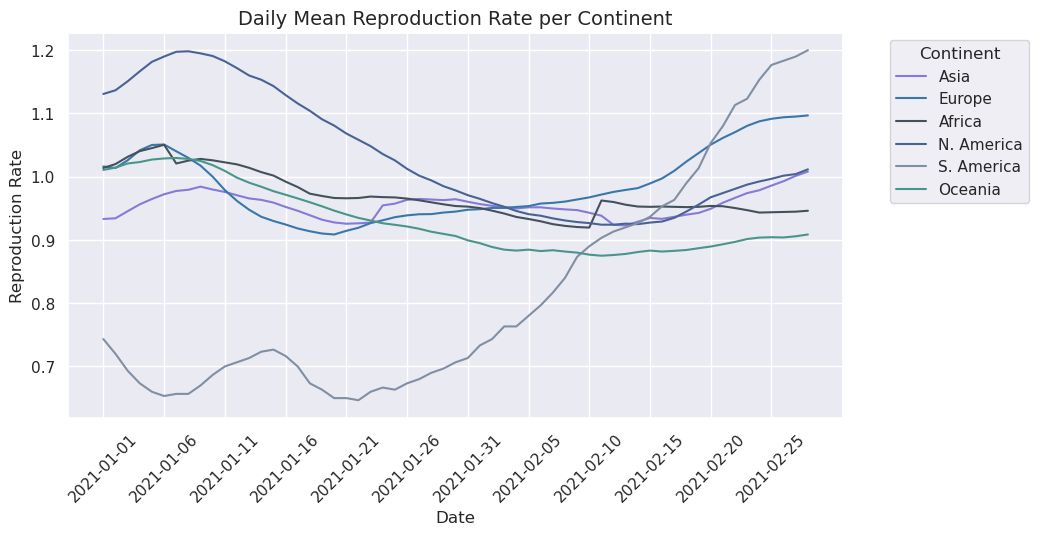

In [39]:
sns.set(style = "darkgrid")

fig, ax = plt.subplots(1, 1, figsize=(10,5))

for key, col, lab in zip(daily_means,
                             [othercol1, othercol2, othercol3, mycol, mycomplcol, othercol4],
                             ['Asia', 'Europe', 'Africa', 'N. America', 'S. America', 'Oceania']): 
    ax.plot(alt_dts_list, daily_means[key], color=col, label = lab)
    
ax.set_xlabel("Date")
ax.set_ylabel("Reproduction Rate")
ax.set_title("Daily Mean Reproduction Rate per Continent", fontsize=14)
tick_marks = np.arange(len(alt_dts_list))
ax.set_xticks(tick_marks[::5])
ax.set_xticklabels(alt_dts_list[::5], rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, title="Continent")
plt.show()

matplotlib.rc_file_defaults()

In [40]:
countries_frame = df.select("location").distinct().collect()
exclusion_list = ['Europe', 'World', 'Asia', 'North America', 'South America', 'Africa', 'Oceania', 'Upper middle income']
countries_list = [str(countries_frame[x][0]) for x in range(len(countries_frame)) if str(countries_frame[x][0]) not in exclusion_list]

In [41]:
country_dict = {}
for country in countries_list:
    filtered = df.filter(F.col('location') == country).filter(F.col('excess_mortality') != 0.0)
    if filtered.count() > 5:
        value = filtered.stat.corr("excess_mortality", "new_tests_smoothed")
    else:
        value = np.nan
    if not np.isnan(value):
        country_dict[country] = value

In [42]:
country_dict = dict(sorted(country_dict.items(), reverse=True, key=lambda item: item[1]))
print("As far as the correlation between new tests and excess mortality is concerned:\n")
print("The ten countries with the highest correlation are:")
for i, ct in enumerate(country_dict):
    if i == 10: break
    print(f"{ct}, with correlation equal to {country_dict[ct]:.3f}.")
country_dict = dict(sorted(country_dict.items(), reverse=False, key=lambda item: item[1]))
print("\nThe ten countries with the lowest correlation are:")
for i, ct in enumerate(country_dict):
    if i == 10: break
    print(f"{ct}, with correlation equal to {country_dict[ct]:.3f}.")

As far as the correlation between new tests and excess mortality is concerned:

The ten countries with the highest correlation are:
Spain, with correlation equal to 0.968.
South Africa, with correlation equal to 0.967.
Peru, with correlation equal to 0.962.
Portugal, with correlation equal to 0.959.
Mexico, with correlation equal to 0.919.
Colombia, with correlation equal to 0.916.
United States, with correlation equal to 0.793.
Lithuania, with correlation equal to 0.762.
Ecuador, with correlation equal to 0.670.
Chile, with correlation equal to 0.647.

The ten countries with the lowest correlation are:
Slovakia, with correlation equal to -0.883.
Denmark, with correlation equal to -0.820.
Romania, with correlation equal to -0.762.
New Zealand, with correlation equal to -0.723.
Switzerland, with correlation equal to -0.715.
Italy, with correlation equal to -0.698.
Sweden, with correlation equal to -0.643.
Luxembourg, with correlation equal to -0.519.
Guatemala, with correlation equal to

In [43]:
country_dict = {}
for country in countries_list:
    filtered = df.filter(F.col('location') == country).filter(F.col('excess_mortality') != 0.0)
    if filtered.count() > 5:
        value = filtered.stat.corr("excess_mortality", "total_vaccinations")
    else:
        value = np.nan
    if not np.isnan(value):
        country_dict[country] = value

In [44]:
country_dict = dict(sorted(country_dict.items(), reverse=True, key=lambda item: item[1]))
print("As far as the correlation between excess mortality and the course of the vaccinations is concerned:\n")
print("The ten countries with the highest correlation are:")
for i, ct in enumerate(country_dict):
    if i == 10: break
    print(f"{ct}, with correlation equal to {country_dict[ct]:.3f}.")
country_dict = dict(sorted(country_dict.items(), reverse=False, key=lambda item: item[1]))
print("\nThe ten countries with the lowest correlation are:")
for i, ct in enumerate(country_dict):
    if i == 10: break
    print(f"{ct}, with correlation equal to {country_dict[ct]:.3f}.")

As far as the correlation between excess mortality and the course of the vaccinations is concerned:

The ten countries with the highest correlation are:
Croatia, with correlation equal to 0.937.
Cyprus, with correlation equal to 0.694.
Malta, with correlation equal to 0.667.
Peru, with correlation equal to 0.584.
Chile, with correlation equal to 0.400.
Finland, with correlation equal to 0.379.
Ecuador, with correlation equal to 0.325.
Greece, with correlation equal to 0.246.
Bulgaria, with correlation equal to 0.208.
Australia, with correlation equal to 0.010.

The ten countries with the lowest correlation are:
Germany, with correlation equal to -0.986.
United States, with correlation equal to -0.985.
Switzerland, with correlation equal to -0.954.
Denmark, with correlation equal to -0.953.
Sweden, with correlation equal to -0.945.
Belgium, with correlation equal to -0.926.
Latvia, with correlation equal to -0.893.
Canada, with correlation equal to -0.877.
Poland, with correlation equal

In [45]:
this_day = dates_list[-1]
filtered_df = df.filter(F.col('date') == this_day)

mean_fem_smokers = filtered_df.filter(F.col('female_smokers') != 0.0).select(F.mean(F.col('female_smokers'))).collect()[0][0]
mean_male_smokers = filtered_df.filter(F.col('male_smokers') != 0.0).select(F.mean(F.col('male_smokers'))).collect()[0][0]
mean_diabetes = filtered_df.filter(F.col('diabetes_prevalence') != 0.0).select(F.mean(F.col('diabetes_prevalence'))).collect()[0][0]
mean_card = filtered_df.filter(F.col('cardiovasc_death_rate') != 0.0).select(F.mean(F.col('cardiovasc_death_rate'))).collect()[0][0]

print(f'Based on data up to {this_day}, the mean percentage of female smokers is {mean_fem_smokers:.2f}%, while the corresponding number for male smokers is {mean_male_smokers:.2f}%.')
print(f'In addition, the mean percentage of people suffering from diabetes (aged 20-79) is {mean_diabetes:.2f}%, while the mean number of deaths per 100.000 people due to cardiovascular conditions is {mean_card:.2f}.')

Based on data up to 2021-02-28, the mean percentage of female smokers is 10.40%, while the corresponding number for male smokers is 32.69%.
In addition, the mean percentage of people suffering from diabetes (aged 20-79) is 8.25%, while the mean number of deaths per 100.000 people due to cardiovascular conditions is 263.47.


In [46]:
filtered_df = filtered_df.filter(F.col('diabetes_prevalence') != 0.0).filter(F.col('cardiovasc_death_rate') != 0.0).filter(F.col('female_smokers') != 0.0).filter(F.col('male_smokers') != 0.0)
filtered_df.orderBy("excess_mortality_cumulative_per_million", ascending=False).select(["location", "excess_mortality_cumulative_per_million", "female_smokers", "male_smokers", "diabetes_prevalence", "cardiovasc_death_rate"]).toPandas().head(5)

,location,excess_mortality_cumulative_per_million,female_smokers,male_smokers,diabetes_prevalence,cardiovasc_death_rate
0,Armenia,3613.388641,1.5,52.1,7.11,341.010
1,Mexico,3461.937774,6.9,21.4,13.06,152.783
2,Belarus,3287.984465,10.5,46.1,5.18,443.129
3,Russia,3151.540865,23.4,58.3,6.18,431.297
4,Albania,2854.503445,7.1,51.2,10.08,304.195


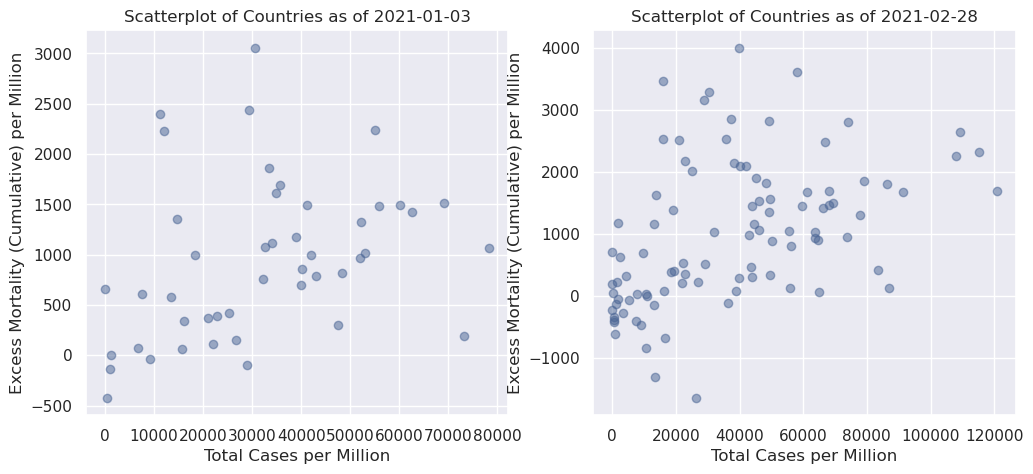

In [47]:
sns.set(style = "darkgrid")
    
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(12,5))

for idx, (ax,this_day) in enumerate(zip([ax1,ax2],[exc_dates_list[0],exc_dates_list[-1]])):
    
    eff_df = df.filter(F.col('excess_mortality_cumulative_per_million') != 0.0).filter(F.col('date') == this_day).select(['total_cases_per_million','excess_mortality_cumulative_per_million','location'])

    pdf = eff_df.select(['total_cases_per_million','excess_mortality_cumulative_per_million']).toPandas()

    points = ax.scatter(pdf.total_cases_per_million, pdf.excess_mortality_cumulative_per_million,
                                  color=mycol, alpha=0.5)

    ax.set_title(f'Scatterplot of Countries as of {this_day}')
    ax.set_xlabel('Total Cases per Million')
    ax.set_ylabel('Excess Mortality (Cumulative) per Million')

plt.show()

matplotlib.rc_file_defaults()

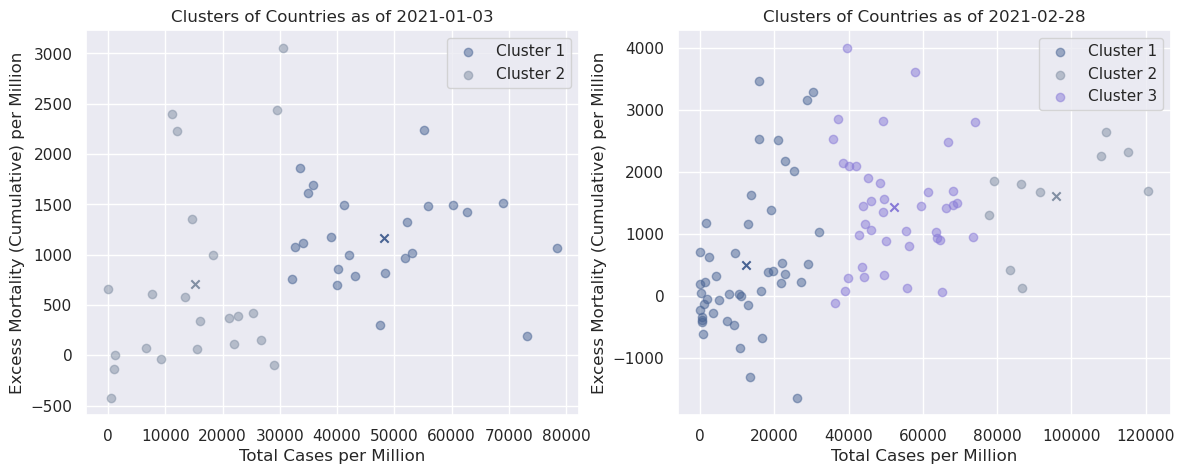

In [48]:
from pyspark.ml.clustering import KMeans

sns.set(style = "darkgrid")

numclusters = [2,3]
colors = [mycol, mycomplcol, othercol1, othercol2, othercol3, othercol4]
    
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(14,5))

for idx, (ax,this_day) in enumerate(zip([ax1,ax2],[exc_dates_list[0],exc_dates_list[-1]])):
    
    eff_df = df.filter(F.col('excess_mortality_cumulative_per_million') != 0.0).filter(F.col('date') == this_day).filter(F.col('date') == this_day).select(['total_cases_per_million','excess_mortality_cumulative_per_million','location'])

    vectorAssembler = VectorAssembler(inputCols = ['total_cases_per_million','excess_mortality_cumulative_per_million'], outputCol = "features")
    feat_df = vectorAssembler.transform(eff_df)
    feat_df = feat_df.select(['features','location'])

    kmeans = KMeans().setK(numclusters[idx]).setSeed(1).setFeaturesCol("features").setPredictionCol("cluster")
    model = kmeans.fit(feat_df)
    transformed = model.transform(feat_df)
    centroids = model.clusterCenters()

    transformed = transformed.join(eff_df, 'location')
    
    clusters, centers, images = {}, {}, {}

    for i in range(numclusters[idx]):

        clusters[i] = transformed.filter(F.col('cluster')==i).select(['location','cluster','total_cases_per_million',
                                                              'excess_mortality_cumulative_per_million']).toPandas().set_index('location')

        images[i] = ax.scatter(clusters[i].total_cases_per_million, clusters[i].excess_mortality_cumulative_per_million,
                                  color=colors[i], alpha=0.5)
        centers[i] = ax.scatter(centroids[i][0], centroids[i][1], color=colors[i], marker='x')

    clusttuple = (images[i] for i in range(numclusters[idx]))
    clustnames = ('Cluster '+str(i+1) for i in range(numclusters[idx]))

    ax.legend(clusttuple, clustnames, loc='best')

    ax.set_title(f'Clusters of Countries as of {this_day}')
    ax.set_xlabel('Total Cases per Million')
    ax.set_ylabel('Excess Mortality (Cumulative) per Million')

plt.show()

matplotlib.rc_file_defaults()

In [49]:
print(*clusters[2].index, sep=', ')


Albania, Armenia, Aruba, Austria, Belgium, Bosnia and Herzegovina, Brazil, Bulgaria, Chile, Colombia, Costa Rica, Croatia, Cyprus, Denmark, Estonia, France, French Polynesia, Georgia, Hungary, Ireland, Italy, Kosovo, Latvia, Lebanon, Liechtenstein, Lithuania, Malta, Moldova, Monaco, Netherlands, North Macedonia, Peru, Poland, Qatar, Romania, Serbia, Spain, Sweden, Switzerland, United Kingdom


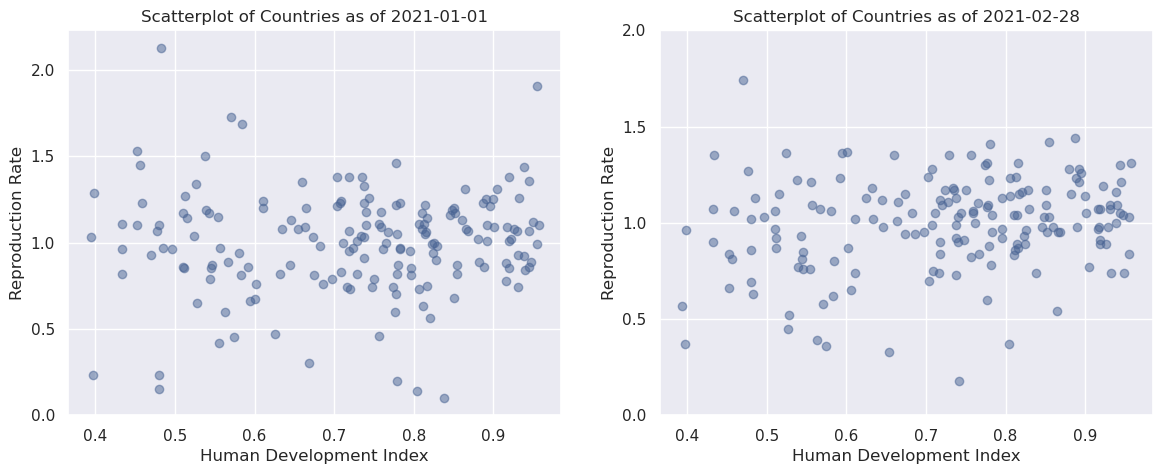

In [50]:
sns.set(style = "darkgrid")
    
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(14,5))

for idx, (ax,this_day) in enumerate(zip([ax1,ax2],[dates_list[0],dates_list[-1]])):
    
    eff_df = df.filter(F.col('human_development_index') != 0.0).filter(F.col('reproduction_rate') != 0.0).filter(F.col('date') == this_day).select(['human_development_index','reproduction_rate','location'])

    pdf = eff_df.select(['human_development_index','reproduction_rate']).toPandas()

    points = ax.scatter(pdf.human_development_index, pdf.reproduction_rate, color=mycol, alpha=0.5)

    ax.set_title(f'Scatterplot of Countries as of {this_day}')
    ax.set_yticks([0.0,0.5,1.0,1.5,2.0])
    ax.set_xlabel('Human Development Index')
    ax.set_ylabel('Reproduction Rate')

plt.show()

matplotlib.rc_file_defaults()

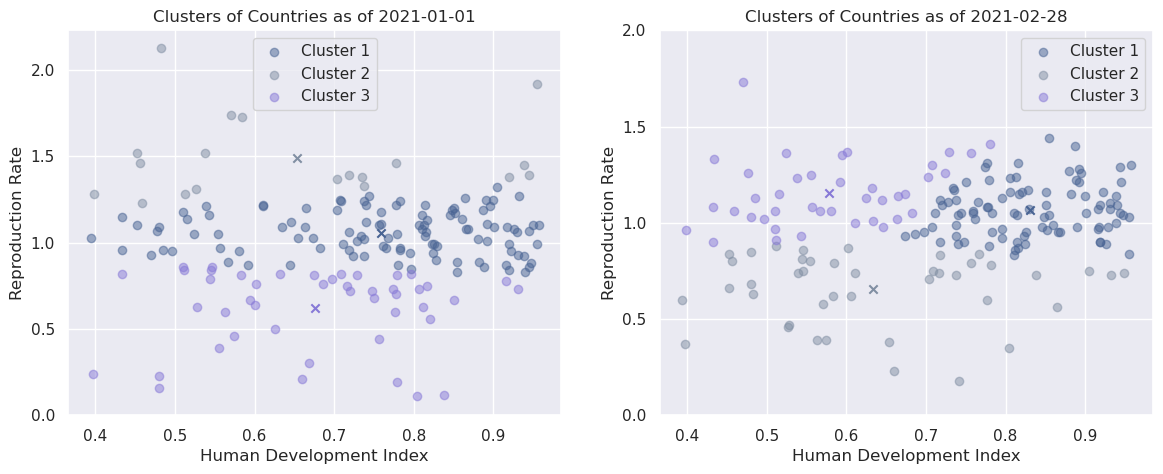

In [49]:
sns.set(style = "darkgrid")

numclusters = [3,3]
colors = [mycol, mycomplcol, othercol1, othercol2, othercol3, othercol4]
    
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(14,5))

for idx, (ax,this_day) in enumerate(zip([ax1,ax2],[dates_list[0],dates_list[-1]])):
    
    eff_df = df.filter(F.col('human_development_index') != 0.0).filter(F.col('reproduction_rate') != 0.0).filter(F.col('date') == this_day).select(['human_development_index','reproduction_rate','location'])

    vectorAssembler = VectorAssembler(inputCols = ['human_development_index','reproduction_rate'], outputCol = "features")
    feat_df = vectorAssembler.transform(eff_df)
    feat_df = feat_df.select(['features','location'])

    kmeans = KMeans().setK(numclusters[idx]).setSeed(1).setFeaturesCol("features").setPredictionCol("cluster")
    model = kmeans.fit(feat_df)
    transformed = model.transform(feat_df)
    centroids = model.clusterCenters()

    transformed = transformed.join(eff_df, 'location')
    
    clusters, centers, images = {}, {}, {}

    for i in range(numclusters[idx]):

        clusters[i] = transformed.filter(F.col('cluster')==i).select(['location','cluster','reproduction_rate',
                                                              'human_development_index']).toPandas().set_index('location')

        images[i] = ax.scatter(clusters[i].human_development_index, clusters[i].reproduction_rate, color=colors[i], alpha=0.5)
        centers[i] = ax.scatter(centroids[i][0], centroids[i][1], color=colors[i], marker='x')

    clusttuple = (images[i] for i in range(numclusters[idx]))
    clustnames = ('Cluster '+str(i+1) for i in range(numclusters[idx]))

    ax.legend(clusttuple, clustnames, loc='best')

    ax.set_title(f'Clusters of Countries as of {this_day}')
    ax.set_yticks([0.0,0.5,1.0,1.5,2.0])
    ax.set_xlabel('Human Development Index')
    ax.set_ylabel('Reproduction Rate')

plt.show()

matplotlib.rc_file_defaults()